# Working with final df to scale everything.

In [106]:
import pandas as pd
from path import Path

import requests
import pprint
import requests
from requests.exceptions import HTTPError
from datetime import datetime as dt
import pandas as pd
import numpy as np
import timeit
import time
import datetime
import copy

import numpy as np
from sklearn import preprocessing
%matplotlib inline

import pandas as pd
from path import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

import plotly.express as px

import matplotlib.pyplot as plt

In [107]:
file_path = Path("../../../../data/cleandata/test_and_post_ico/ico_test_df.csv")

In [108]:
success_df = pd.read_csv(file_path)

In [109]:
success_df.drop(columns = ['custom_index_scaled','custom_index', 'success_index'], inplace = True)

In [110]:
success_df.head(1)

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success_PCA,predicted_NN,success
0,35.0,0x,ZRX,210898190,0.731445,195643,0.29,-1.2,-4.96,United States of America,...,0 days 00:00:00.000000000,-0.115233,0.022333,0.029333,0.948333,3.0,364.0,0,0.000003,0.0


In [111]:
success_df.shape

(535, 29)

# drop unncessary columns and scale all

In [112]:
success_df.columns

Index(['rank_cnc', 'Name', 'Ticker', 'market_cap', 'price', 'volume24',
       'pct1h', 'pct24h', 'pct7d', 'country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'rating', 'status', 'type', 'End', 'Start', 'Duration',
       'pre_Duration', 'compound', 'negative', 'neutral', 'positive',
       'no_of_posts', 'Longevity', 'success_PCA', 'predicted_NN', 'success'],
      dtype='object')

In [113]:
success_df.drop(columns = ['country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'status', 'type', 'End', 'Start', 'predicted_NN', 'success_PCA', 'price'], inplace = True)

In [114]:
success_df.columns

Index(['rank_cnc', 'Name', 'Ticker', 'market_cap', 'volume24', 'pct1h',
       'pct24h', 'pct7d', 'rating', 'Duration', 'pre_Duration', 'compound',
       'negative', 'neutral', 'positive', 'no_of_posts', 'Longevity',
       'success'],
      dtype='object')

In [115]:
success_df['pre_Duration'].head()

0    0 days 00:00:00.000000000
1    0 days 00:00:00.000000000
2    0 days 00:00:00.000000000
3    0 days 00:00:00.000000000
4    0 days 00:00:00.000000000
Name: pre_Duration, dtype: object

In [116]:
def removing_days(df):
    
    for i in range(len(df)) : 
        #print(str(df.at[i,"pre_Duration"])[:-24])
        df.at[i,'pre_Duration'] = int(str(df.at[i, "pre_Duration"])[:-24])
    return df

In [117]:
removing_days(success_df).head()

,rank_cnc,Name,Ticker,market_cap,volume24,pct1h,pct24h,pct7d,rating,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success
0,35.0,0x,ZRX,210898190,195643,0.29,-1.20,-4.96,2.6,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0,0.0
1,359.0,Perlin,PERL,7547077,23506334,0.79,1.16,-8.86,4.6,49,0,0.817167,0.053167,0.830500,0.116000,6.0,367.0,0.0
2,823.0,Medicalchain,MTN,1279470,52,-0.20,-34.19,-6.05,5.0,86,0,0.746697,0.025394,0.892535,0.082042,71.0,381.0,0.0
3,1310.0,GoPower,GPT,204249,0,0.00,-0.06,5.58,3.3,60,0,-0.356840,0.016600,0.975800,0.007200,5.0,381.0,0.0
4,603.0,Swarm,SWM,2752050,5,-0.21,-5.07,2.12,3.5,13,0,0.435584,0.069211,0.032684,0.898158,19.0,381.0,0.0


In [118]:
success_df['pre_Duration'] = success_df['pre_Duration'].astype(int)

In [119]:
# Note above
#removing_days(success_df)

In [120]:
success_df.dtypes

rank_cnc        float64
Name             object
Ticker           object
market_cap        int64
volume24          int64
pct1h           float64
pct24h          float64
pct7d           float64
rating          float64
Duration          int64
pre_Duration      int32
compound        float64
negative        float64
neutral         float64
positive        float64
no_of_posts     float64
Longevity       float64
success         float64
dtype: object

In [121]:
success_df.head(1)

,rank_cnc,Name,Ticker,market_cap,volume24,pct1h,pct24h,pct7d,rating,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success
0,35.0,0x,ZRX,210898190,195643,0.29,-1.2,-4.96,2.6,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0,0.0


In [122]:
#these kept coming up as an issue...
success_df.replace("1,284.19","1284.19", inplace=True)

success_df.replace("-126 d","-126", inplace=True)

In [123]:
file_path = Path("../../../../data/cleandata/1hot_merged_post_ICO.csv")
df = pd.read_csv(file_path)

In [124]:
df = df[['Name','Ticker','Twitter_Compound', 'Twitter_Negative', 'Twitter_Neutral','Twitter_Positive']]

In [125]:
#merging twitter and success by Name
success_df = pd.merge(left=success_df, right=df, left_on='Name', right_on='Name')

In [126]:
success_df.drop(columns = ['Name', 'Ticker_x', 'Ticker_y'], inplace = True)

In [127]:
success_df.columns

Index(['rank_cnc', 'market_cap', 'volume24', 'pct1h', 'pct24h', 'pct7d',
       'rating', 'Duration', 'pre_Duration', 'compound', 'negative', 'neutral',
       'positive', 'no_of_posts', 'Longevity', 'success', 'Twitter_Compound',
       'Twitter_Negative', 'Twitter_Neutral', 'Twitter_Positive'],
      dtype='object')

In [128]:
success_df.dtypes
# Removing ETH... very successful but highly skewing the processes. Needed when you are using ETH!
#success_df = success_df.iloc[1:]

rank_cnc            float64
market_cap            int64
volume24              int64
pct1h               float64
pct24h              float64
pct7d               float64
rating              float64
Duration              int64
pre_Duration          int64
compound            float64
negative            float64
neutral             float64
positive            float64
no_of_posts         float64
Longevity           float64
success             float64
Twitter_Compound    float64
Twitter_Negative    float64
Twitter_Neutral     float64
Twitter_Positive    float64
dtype: object

### Start PCA

In [129]:
success_scaled = StandardScaler().fit_transform(success_df)

In [130]:
success_scaled

array([[-1.46339295,  0.80057162, -0.1090052 , ..., -0.35089677,
         0.62489674, -0.78258118],
       [-0.93662757, -0.10858557,  0.15757469, ...,  0.449811  ,
         0.51067195, -0.68201754],
       [-0.18224751, -0.13660725, -0.11124197, ...,  0.04071244,
         0.30293267,  0.51907275],
       ...,
       [-1.01304106, -0.09832618, -0.11123235, ...,  1.34804087,
         0.32146644, -0.28225373],
       [-1.4081151 ,  0.20252329,  0.16943024, ..., -0.72444633,
         0.52680263, -0.11685102],
       [-1.28455285, -0.03267193, -0.107162  , ..., -0.72444633,
         0.13785305,  1.71298487]])

In [141]:
pca = PCA(n_components=6)

In [142]:
success_scaled.shape[1] #number of features... ie, the number of components minus 1 we can use.

20

In [143]:
success_pca = pca.fit_transform(success_scaled)

In [145]:
# Transform PCA data to a DataFrame
df_success_pca = pd.DataFrame(
    data=success_pca, columns=["principal component 1", "principal component 2", 'principal component 3', 'principal component 4','principal component 5','principal component 6'])
df_success_pca.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,0.843943,0.160179,0.082077,0.233779,0.034743,1.648387
1,-0.475742,-0.029405,1.523160,-1.246973,-0.131856,-0.845201
2,-1.105605,0.209994,0.515133,-2.792764,0.266939,-0.803782
3,-1.914812,-0.405088,1.142618,-0.769082,0.569510,0.678509
4,1.280394,-0.741815,-0.389472,-0.738458,-0.268929,-0.502905


In [146]:
pca.explained_variance_ratio_.sum() #horrible but 3 what we need according to the elbow curve

0.5664890695379774

In [147]:
# Finding the best value for k
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_success_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

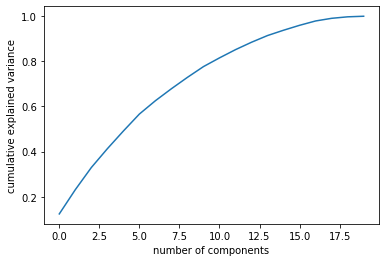

In [148]:
pca = PCA().fit(success_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [153]:
# Predicting clusters with k=3 USED 3 there is an outlier.... 

# Initialize the K-Means model
model = KMeans(n_clusters=6, random_state=0)

# Fit the model
model.fit(df_success_pca)

# Predict clusters
predictions = model.predict(df_success_pca)

# Add the predicted class columns
df_success_pca["class"] = model.labels_
df_success_pca['class'].value_counts()

0    171
3    150
1     85
4     82
2      8
5      5
Name: class, dtype: int64

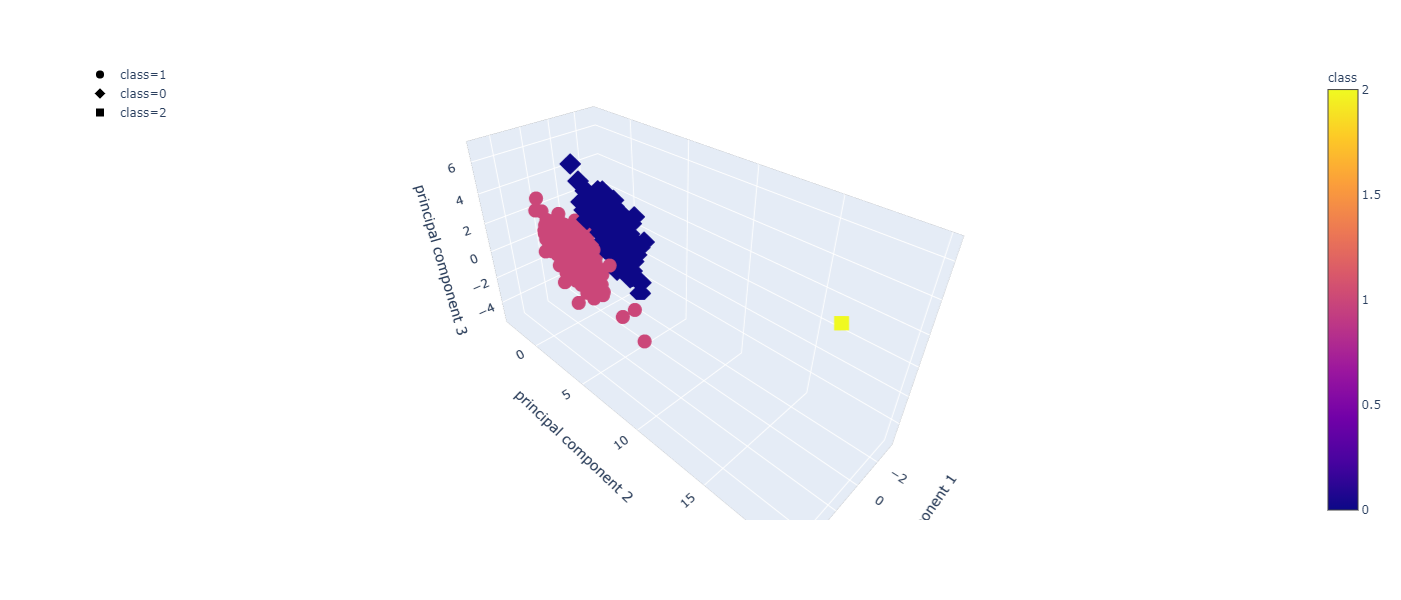

In [150]:
fig = px.scatter_3d(
    df_success_pca,
    x="principal component 1",
    y="principal component 2",
    z="principal component 3",
    color="class",
    symbol="class",
    #size="sepal_width",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

### Outlier removed. The highest market cap was causing this model to fail with a huge outlier.
### Removed. What is shown is now more telling.

In [266]:
success_df_pca_class_2 = pd.read_csv(file_path)

In [287]:
success_df_pca_class_2.drop(columns = ['custom_index','custom_index_scaled','success_index'], inplace = True)

In [288]:
success_df_pca_class_2['success_PCA'] = 0

In [289]:
success_df_pca_class_2.iloc[list(df_success_pca[df_success_pca['class'] == 2].index)]

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,Start,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success_PCA
78,8.0,Cardano,ADA,3214893394,3.420000,1735988258,0.11,-1.49,-2.55,Switzerland,...,2015-09-01 00:00:00,350,0,0.828470,0.032200,0.858550,0.109270,100.0,522.0,0
404,22.0,Ethereum Classic,ETC,632251075,69.070000,346367843,-0.12,-1.18,-5.06,NaN,...,2017-09-28 03:00:00,0,0,0.663146,0.102770,0.025100,0.872110,100.0,779.0,0
438,23.0,Basic Attenti...,BAT,547458892,4.760000,642121534,-0.20,-2.10,-9.16,United States of America,...,2017-05-31 00:00:00,0,0,0.377329,0.079930,0.037850,0.882180,100.0,779.0,0
481,7.0,EOS,EOS,3277372658,21.070000,231846713,-0.46,-1.33,2.49,Cayman Islands,...,2017-06-26 16:00:00,20,0,0.563773,0.096670,0.041410,0.861890,100.0,848.0,0
524,13.0,Huobi Token,HT,1105888653,0.042654,53437224,-0.50,-1.72,-2.12,Seychelles,...,2017-09-28 03:00:00,488,0,0.589474,0.098387,0.032946,0.868753,93.0,1049.0,0


In [290]:
success_df_pca_class_2.at[list(df_success_pca[df_success_pca['class'] == 2].index),'success_PCA']=1

In [291]:
success_df_pca_class_2.iloc[list(df_success_pca[df_success_pca['class'] == 2].index)]['success_PCA']

78     1
404    1
438    1
481    1
524    1
Name: success_PCA, dtype: int64

In [292]:
success_df_pca_class_2.head()

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,Start,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success_PCA
0,35.0,0x,ZRX,210898190,0.731445,195643,0.29,-1.20,-4.96,United States of America,...,2017-08-15 00:00:00,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0,0
1,359.0,Perlin,PERL,7547077,0.019287,23506334,0.79,1.16,-8.86,Singapore,...,2017-09-28 03:00:00,49,0,0.817167,0.053167,0.830500,0.116000,6.0,367.0,0
2,823.0,Medicalchain,MTN,1279470,0.000174,52,-0.20,-34.19,-6.05,United Kingdom,...,2018-02-01 00:00:00,86,0,0.746697,0.025394,0.892535,0.082042,71.0,381.0,0
3,1310.0,GoPower,GPT,204249,0.000128,0,0.00,-0.06,5.58,NaN,...,2018-02-27 00:00:00,60,0,-0.356840,0.016600,0.975800,0.007200,5.0,381.0,0
4,603.0,Swarm,SWM,2752050,0.002171,5,-0.21,-5.07,2.12,Liechtenstein,...,2017-10-21 12:00:00,13,0,0.435584,0.069211,0.032684,0.898158,19.0,381.0,0


In [293]:
success_df_pca_class_2.drop(columns = ['predicted_NN'], inplace = True)

KeyError: "['predicted_NN'] not found in axis"

In [294]:
success_df.head(2)

,rank_cnc,market_cap,price,volume24,pct1h,pct24h,pct7d,rating,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity
0,35.0,210898190,0.731445,195643,0.29,-1.20,-4.96,2.6,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0
1,359.0,7547077,0.019287,23506334,0.79,1.16,-8.86,4.6,49,0,0.817167,0.053167,0.830500,0.116000,6.0,367.0


In [295]:
success_df_pca_class_2.replace("1,284.19","1284.19", inplace=True)

success_df_pca_class_2.replace("-126 d","-126", inplace=True)

In [296]:
success_df_pca_class_2.shape

(535, 27)

In [297]:
success_df.shape

(535, 16)

In [298]:
a = set(success_df_pca_class_2['rank_cnc']) 
b = set(success_df['rank_cnc'])
c=(a^b)&b
d=(a^b)&a

In [299]:
d

set()

In [300]:
c

set()

In [301]:
def check_what_matches(df1,df2):
    duplicates = []
    
    for ticker1 in df1['rank_cnc'].tolist():
        for ticker2 in df2['rank_cnc'].tolist():
            if ticker1 != ticker2:
                duplicates.append(ticker1)
            else:
                continue
    return duplicates

In [302]:
# check_what_matches(success_df, success_df_pca_class_2)

In [303]:
#doing it manually.... iterations were not working at all... :\
success_df.columns

Index(['rank_cnc', 'market_cap', 'price', 'volume24', 'pct1h', 'pct24h',
       'pct7d', 'rating', 'Duration', 'pre_Duration', 'compound', 'negative',
       'neutral', 'positive', 'no_of_posts', 'Longevity'],
      dtype='object')

In [304]:
success_df_pca_class_2.columns

Index(['rank_cnc', 'Name', 'Ticker', 'market_cap', 'price', 'volume24',
       'pct1h', 'pct24h', 'pct7d', 'country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'rating', 'status', 'type', 'End', 'Start', 'Duration',
       'pre_Duration', 'compound', 'negative', 'neutral', 'positive',
       'no_of_posts', 'Longevity', 'success_PCA'],
      dtype='object')

In [305]:
for columns in list(success_df.columns):
    success_df_pca_class_2[columns] = success_df[columns]

In [306]:
success_df_pca_class_2.head()

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,Start,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success_PCA
0,35.0,0x,ZRX,210898190,0.731445,195643,0.29,-1.20,-4.96,United States of America,...,2017-08-15 00:00:00,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0,0
1,359.0,Perlin,PERL,7547077,0.019287,23506334,0.79,1.16,-8.86,Singapore,...,2017-09-28 03:00:00,49,0,0.817167,0.053167,0.830500,0.116000,6.0,367.0,0
2,823.0,Medicalchain,MTN,1279470,0.000174,52,-0.20,-34.19,-6.05,United Kingdom,...,2018-02-01 00:00:00,86,0,0.746697,0.025394,0.892535,0.082042,71.0,381.0,0
3,1310.0,GoPower,GPT,204249,0.000128,0,0.00,-0.06,5.58,NaN,...,2018-02-27 00:00:00,60,0,-0.356840,0.016600,0.975800,0.007200,5.0,381.0,0
4,603.0,Swarm,SWM,2752050,0.002171,5,-0.21,-5.07,2.12,Liechtenstein,...,2017-10-21 12:00:00,13,0,0.435584,0.069211,0.032684,0.898158,19.0,381.0,0


In [307]:
file_path = Path("../../../../data/cleandata/success_PCA_df.csv")
success_df_pca_class_2.to_csv(file_path, index=False)